In [1]:
import pandas as pd
import numpy as np
print("✅ Kernel & Library Berjalan Normal!")


✅ Kernel & Library Berjalan Normal!


In [2]:
pip install numpy pandas matplotlib pmdarima statsmodels scikit-learn openpyxl


  Using cached matplotlib-3.10.7-cp310-cp310-win_amd64.whl.metadata (11 kB)
Using cached matplotlib-3.10.7-cp310-cp310-win_amd64.whl (8.1 MB)
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 14.3 MB/s  0:00:00

   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   -------------------------- ------------- 4/6 [conto

📅 Contoh data dari file Excel:


,Jumlah_Pengunjung
Tanggal,
2025-05-01,61
2025-05-02,68
2025-05-03,72
2025-05-04,70
2025-05-05,57


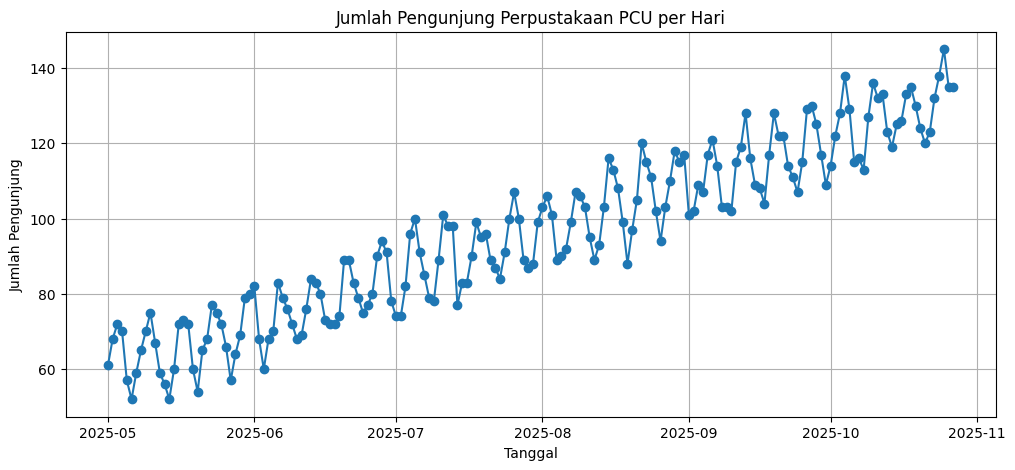

Data Training: 144 data | Data Testing: 36 data
🚀 Tidak ada model tersimpan — mulai training baru...

🔍 Mencari parameter terbaik dengan auto_arima...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=0.86 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=980.814, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=862.289, Time=0.08 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=934.113, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=979.293, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=973.472, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=934.192, Time=0.07 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=881.717, Time=0.04 sec
 ARIMA(2,1,0)(1,0,0)[7] intercept   : AIC=846.832, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[7] intercept   : AIC=

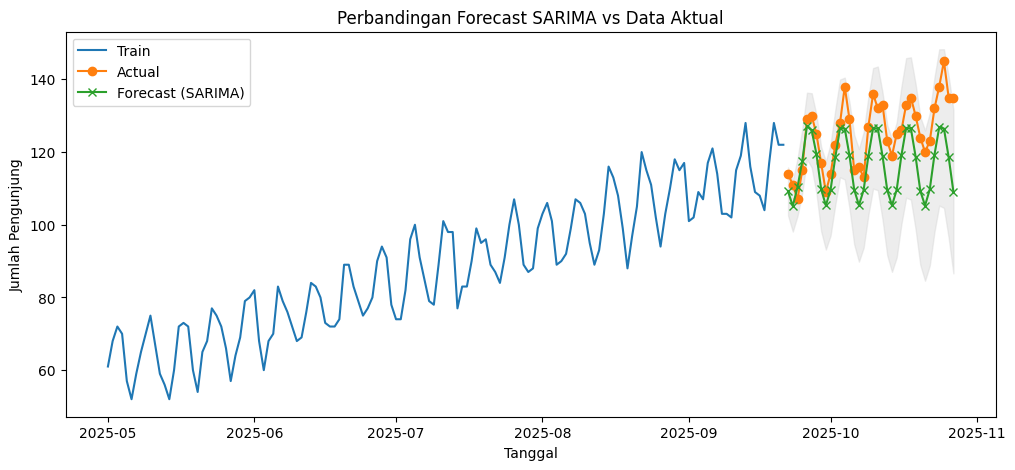

📉 RMSE: 10.620
📈 MAPE: 7.19%


In [3]:
# ================================================================
# 📗 SARIMA Forecasting - Proyek Sistem Informasi Manufaktur (SIMF)
# ================================================================

# ------------------------------------------------
# 1️⃣ IMPORT LIBRARY
# ------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
import joblib
import math
import os
import warnings
warnings.filterwarnings("ignore")

# ------------------------------------------------
# 2️⃣ MEMBACA DATASET DARI FILE EXCEL
# ------------------------------------------------
excel_filename = "dummy_pengunjung_perpustakaan.xlsx"

data = pd.read_excel(excel_filename, parse_dates=['Tanggal'])
data.set_index('Tanggal', inplace=True)
data = data.asfreq('D')  # pastikan data berfrekuensi harian

print("📅 Contoh data dari file Excel:")
display(data.head())

# ------------------------------------------------
# 3️⃣ VISUALISASI DATA
# ------------------------------------------------
plt.figure(figsize=(12, 5))
plt.plot(data.index, data['Jumlah_Pengunjung'], marker='o')
plt.title("Jumlah Pengunjung Perpustakaan PCU per Hari")
plt.xlabel("Tanggal")
plt.ylabel("Jumlah Pengunjung")
plt.grid(True)
plt.show()

# ------------------------------------------------
# 4️⃣ PEMBAGIAN DATA TRAIN & TEST
# ------------------------------------------------
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]
print(f"Data Training: {len(train)} data | Data Testing: {len(test)} data")

# ------------------------------------------------
# 5️⃣ AUTO ARIMA & MODEL TRAINING / LOAD
# ------------------------------------------------
model_path = "sarima_model.pkl"

def train_and_save_model(train_data):
    """Melatih model SARIMA baru dan menyimpannya"""
    print("\n🔍 Mencari parameter terbaik dengan auto_arima...")
    model_auto = auto_arima(
        train_data,
        seasonal=True,
        m=7,  # pola musiman mingguan
        trace=True,
        stepwise=True,
        suppress_warnings=True
    )

    print("\n📊 Parameter terbaik hasil auto_arima:")
    print(model_auto.summary())

    order = model_auto.order
    seasonal_order = model_auto.seasonal_order
    print(f"\nMenggunakan parameter SARIMA{order}x{seasonal_order}")

    print("\n🏋️‍♀️ Melatih model SARIMA...")
    sarima_model = SARIMAX(
        train_data,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    sarima_result = sarima_model.fit(disp=True, maxiter=200)

    joblib.dump({
        "model": sarima_result,
        "last_train_date": train_data.index[-1],
        "order": order,
        "seasonal_order": seasonal_order
    }, model_path)
    print(f"✅ Model berhasil dilatih dan disimpan di: {model_path}")
    return sarima_result

def load_or_retrain(train_data):
    """Memuat model lama, atau retrain jika data baru"""
    if os.path.exists(model_path):
        saved = joblib.load(model_path)
        saved_last_date = pd.to_datetime(saved["last_train_date"])
        current_last_date = train_data.index[-1]

        if current_last_date > saved_last_date:
            print("🔁 Data baru terdeteksi — melakukan retraining...")
            return train_and_save_model(train_data)
        else:
            print("📦 Memuat model SARIMA dari file...")
            return saved["model"]
    else:
        print("🚀 Tidak ada model tersimpan — mulai training baru...")
        return train_and_save_model(train_data)

sarima_result = load_or_retrain(train)

# ------------------------------------------------
# 6️⃣ FORECASTING & VISUALISASI
# ------------------------------------------------
forecast = sarima_result.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

plt.figure(figsize=(12, 5))
plt.plot(train.index, train['Jumlah_Pengunjung'], label='Train')
plt.plot(test.index, test['Jumlah_Pengunjung'], label='Actual', marker='o')
plt.plot(test.index, forecast_mean, label='Forecast (SARIMA)', marker='x')
plt.fill_between(test.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1],
                 color='lightgray', alpha=0.4)
plt.title("Perbandingan Forecast SARIMA vs Data Aktual")
plt.xlabel("Tanggal")
plt.ylabel("Jumlah Pengunjung")
plt.legend()
plt.show()

# ------------------------------------------------
# 7️⃣ EVALUASI MODEL
# ------------------------------------------------
rmse = math.sqrt(mean_squared_error(test, forecast_mean))
mape = np.mean(np.abs((test['Jumlah_Pengunjung'] - forecast_mean) / test['Jumlah_Pengunjung'])) * 100
print(f"📉 RMSE: {rmse:.3f}")
print(f"📈 MAPE: {mape:.2f}%")



🔮 Forecast 6 Hari ke Depan:


,Forecast_Jumlah_Pengunjung,Batas_Bawah,Batas_Atas
Tanggal,,,
2025-10-28,109,103,116
2025-10-29,105,98,112
2025-10-30,110,102,118
2025-10-31,117,109,126
2025-11-01,127,118,136
2025-11-02,126,116,136


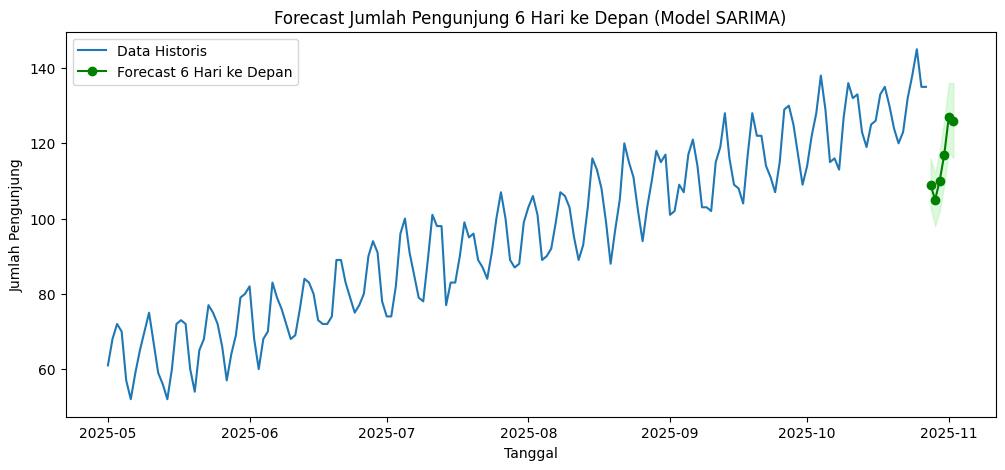

✅ Analisis Forecasting SARIMA selesai dengan sukses!


In [4]:

# ------------------------------------------------
# 8️⃣ FORECAST 6 PERIODE KE DEPAN
# ------------------------------------------------
forecast_next = sarima_result.get_forecast(steps=6)
future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=6)
forecast_next_mean = forecast_next.predicted_mean
forecast_next_ci = forecast_next.conf_int()

forecast_table = pd.DataFrame({
    'Tanggal': future_dates,
    'Forecast_Jumlah_Pengunjung': np.round(forecast_next_mean.values, 0).astype(int),
    'Batas_Bawah': np.round(forecast_next_ci.iloc[:, 0].values, 0).astype(int),
    'Batas_Atas': np.round(forecast_next_ci.iloc[:, 1].values, 0).astype(int)
}).set_index('Tanggal')

print("\n🔮 Forecast 6 Hari ke Depan:")
display(forecast_table)

plt.figure(figsize=(12, 5))
plt.plot(data.index, data['Jumlah_Pengunjung'], label='Data Historis')
plt.plot(forecast_table.index, forecast_table['Forecast_Jumlah_Pengunjung'],
         label='Forecast 6 Hari ke Depan', marker='o', color='green')
plt.fill_between(forecast_table.index, forecast_table['Batas_Bawah'],
                 forecast_table['Batas_Atas'], color='lightgreen', alpha=0.3)
plt.title("Forecast Jumlah Pengunjung 6 Hari ke Depan (Model SARIMA)")
plt.xlabel("Tanggal")
plt.ylabel("Jumlah Pengunjung")
plt.legend()
plt.show()

print("✅ Analisis Forecasting SARIMA selesai dengan sukses!")
